In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv('./splitfiles/z2/train.csv')
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

agg_train = train.groupby('object_id').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train.columns = new_columns
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

del agg_train['mjd_max'], agg_train['mjd_min']
agg_train.head()

del train
gc.collect()

120

In [3]:
meta_train = pd.read_csv('./splitfiles/z2/train_meta.csv')
meta_train.head()

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [15, 42, 52, 62, 64, 67, 88, 90, 95]


In [4]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
    
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [5]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [7]:
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [8]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
    class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [40]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [41]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [42]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [43]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

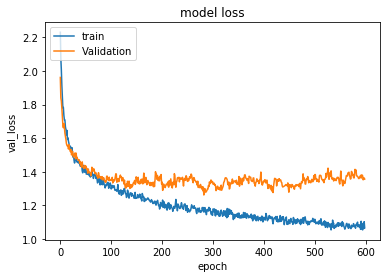

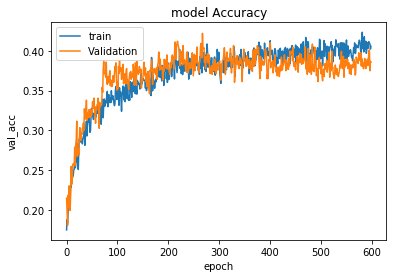

Loading Best Model
1.208948302408184


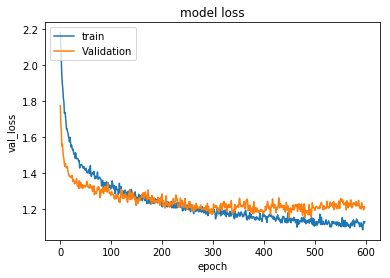

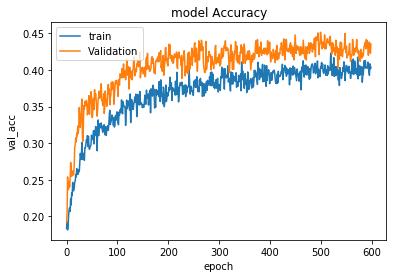

Loading Best Model
1.1140747283133783


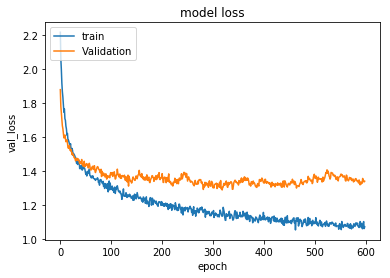

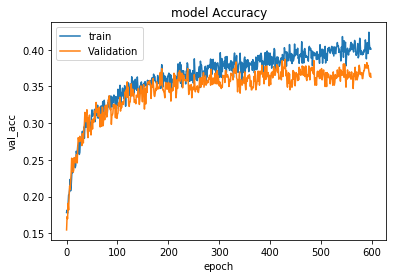

Loading Best Model
1.2395632530266427


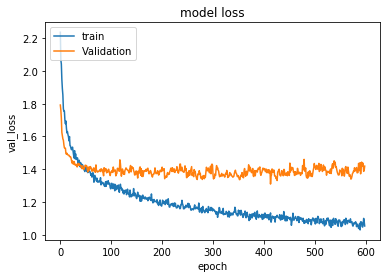

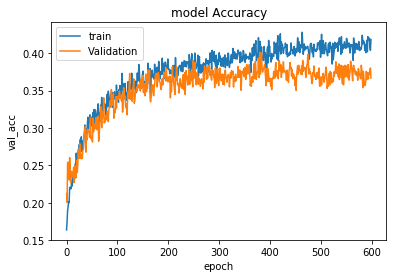

Loading Best Model
1.292712270736289


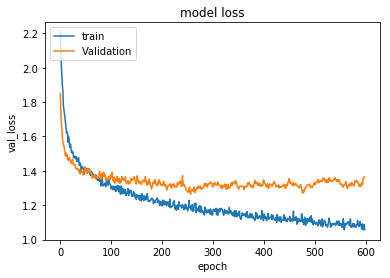

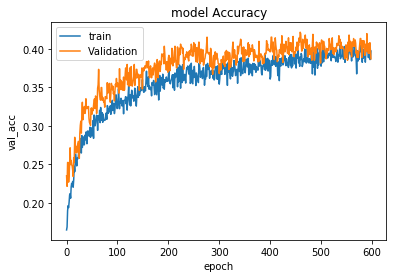

Loading Best Model
1.225301356587332
MULTI WEIGHTED LOG LOSS : 1.21607 


In [44]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 600
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [46]:
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [47]:
sample_sub = pd.read_csv('sample_submission.csv')
class_names = ['class 15', 'class 42', 'class 52', 'class 62', 'class 64', 'class 67', 'class 88', 'class 90', 'class 95']
del sample_sub;gc.collect()

5132

Normalized confusion matrix
[[0.42 0.07 0.09 0.07 0.05 0.18 0.01 0.08 0.03]
 [0.21 0.19 0.14 0.14 0.04 0.15 0.01 0.11 0.03]
 [0.17 0.07 0.26 0.09 0.03 0.19 0.   0.17 0.02]
 [0.2  0.08 0.11 0.2  0.08 0.25 0.   0.06 0.01]
 [0.01 0.   0.01 0.03 0.88 0.05 0.   0.   0.02]
 [0.13 0.01 0.08 0.09 0.05 0.53 0.   0.11 0.01]
 [0.   0.01 0.   0.   0.01 0.   0.96 0.01 0.01]
 [0.16 0.02 0.14 0.03 0.02 0.23 0.01 0.37 0.02]
 [0.01 0.01 0.   0.   0.02 0.01 0.   0.02 0.93]]


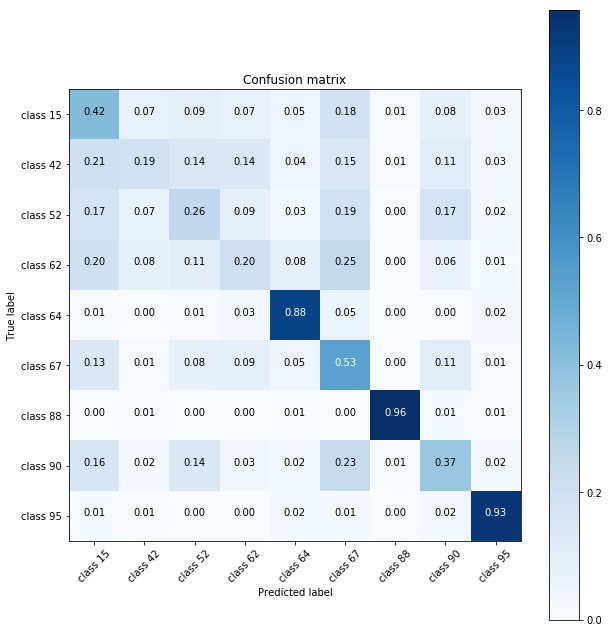

In [48]:
plt.figure(figsize=(9,9))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [50]:
meta_test = pd.read_csv('./splitfiles/z2/test_meta.csv')

import time

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('test_set.csv', chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # Group by object id
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test.columns = new_columns
    agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

    del agg_test['mjd_max'], agg_test['mjd_min']
#     del df
#     gc.collect()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('prediction_z2.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('prediction_z2.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds
#     print('done')
    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f minutesminutes' % (chunks * (i_c + 1), (time.time() - start) / 60))

/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

       50000000 done in   8.0 minutesminutes


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      100000000 done in  15.9 minutesminutes


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      150000000 done in  24.2 minutesminutes


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      200000000 done in  31.8 minutesminutes


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      250000000 done in  39.5 minutesminutes


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      300000000 done in  47.2 minutesminutes


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      350000000 done in  54.8 minutesminutes


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      400000000 done in  62.5 minutesminutes


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      450000000 done in  70.6 minutesminutes


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [2]:
z = pd.read_csv('prediction_z2.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('single_predictions_z2.csv', index=True)

2
88


In [3]:
z.head()

,class 15,class 42,class 52,class 62,class 64,class 67,class 88,class 90,class 95,class_99
object_id,,,,,,,,,,
13,0.011681,0.386515,0.331080,0.181171,0.000069,0.004188,0.000529,0.084751,0.000016,0.152174
14,0.008519,0.093386,0.222437,0.044581,0.000431,0.120280,0.004213,0.504618,0.001534,0.145497
17,0.008509,0.107411,0.159897,0.052025,0.000334,0.098943,0.070679,0.495743,0.006460,0.148697
23,0.007273,0.101106,0.161032,0.049526,0.000308,0.094320,0.003695,0.574587,0.008153,0.136249
34,0.008217,0.098738,0.125522,0.113508,0.000344,0.222791,0.000009,0.426434,0.004436,0.154650
